# ML Decision tree - hyperparameter tuning
THis notebook demomstrates using hyperparamter tuning functionality to find the best hyperparamters for this classification algorithm.


In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import pathlib

In [2]:
import ipywidgets
import time

In [3]:
import pandas
import numpy
import matplotlib
import matplotlib.pyplot

In [4]:
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.ensemble
import sklearn.metrics

In [5]:
root_repo_dir = pathlib.Path().absolute().parent
sys.path = [os.path.join(root_repo_dir)] + sys.path

In [6]:
import xbt.dataset
from xbt.dataset import XbtDataset, UNKNOWN_STR, cat_output_formatter, check_value_found
from xbt.imeta import imeta_classification, XBT_MAX_DEPTH

In [7]:
# Set up some site specific parameters for the notebook
try:
    environment = os.environ['XBT_ENV_NAME']
except KeyError:
    environment = 'pangeo'

In [8]:
root_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/',
    'pangeo': '/data/misc/xbt-data/',
}
env_date_ranges = {
    'MO_scitools': (1966,2015),
    'pangeo': (1966,2015)
}

In [9]:
# Set up some dataset specific parameters
root_data_dir = root_data_dirs[environment]
year_range = env_date_ranges[environment]

In [10]:
experiment_name = 'nb_single_decisionTree_latLon'
classifier_class = sklearn.tree.DecisionTreeClassifier
classifier_opts = {'max_depth': 20,
                   'min_samples_leaf': 1,
                   'criterion': 'gini'
                  }
classifier_name = 'decision_tree'
suffix='countryLatLon'


In [11]:
cv_metric_names = ['f1_weighted','precision_weighted','recall_weighted']
input_feature_names = ['max_depth', 'year', 'lat', 'lon', 'country']
# hp_tune_metric = 'recall_micro'
hp_tune_metric = 'recall_weighted'
num_train_splits = 3

In [12]:
input_dir_name = 'csv_with_imeta'
exp_out_dir_name = 'experiment_outputs'

In [13]:
xbt_input_dir = os.path.join(root_data_dir, input_dir_name)
xbt_output_dir = os.path.join(root_data_dir, exp_out_dir_name, experiment_name)

In [14]:
# create the output for this experiment if it doesn't exist
if not os.path.isdir(xbt_output_dir):
    os.makedirs(xbt_output_dir)
print(f'outputting to {xbt_output_dir}')

outputting to /data/users/shaddad/xbt-data/experiment_outputs/nb_single_decisionTree_latLon


In [15]:
output_fname_template = 'xbt_output_{classifier}_{suffix}.csv'
result_fname_template = 'xbt_metrics_{classifier}_{suffix}.csv'

In [16]:
%%time
xbt_full_dataset = XbtDataset(xbt_input_dir, year_range)

CPU times: user 1min, sys: 12.1 s, total: 1min 13s
Wall time: 3min 48s


In [17]:
classifier_param_grid = {
    'max_depth': [1,5,10,20], 
    'min_samples_leaf': [1,2,5], 
    'criterion': ['gini', 'entropy']
},

## Data preparation

Data preparation is the same as for the standard imeta ML tree notebook, but with latitude and longitude replacing country code as an input feature. As previously the data is split into unseen, test and train for evaluating performance, and same hyper parameter values are used in decision tree. This time we are only using instrument as a target value, as there not shown to be benefit in training for model and manufacturer separately.

In [18]:
%%time
xbt_labelled = xbt_full_dataset.filter_obs({'labelled': 'labelled'})

CPU times: user 220 ms, sys: 18.6 ms, total: 239 ms
Wall time: 237 ms


In [19]:
_ = xbt_labelled.get_ml_dataset(return_data = False)

In [20]:
_ = xbt_labelled.filter_features(['instrument','model','manufacturer']).encode_target(return_data = False)

In [21]:
%%time
unseen_cruise_numbers = xbt_labelled.sample_feature_values('cruise_number', fraction=0.1)

CPU times: user 23.1 ms, sys: 1.02 ms, total: 24.1 ms
Wall time: 21.8 ms


In [22]:
%%time
xbt_unseen = xbt_labelled.filter_obs({'cruise_number': unseen_cruise_numbers}, mode='include', check_type='in_filter_set')
xbt_working = xbt_labelled.filter_obs({'cruise_number': unseen_cruise_numbers}, mode='exclude', check_type='in_filter_set')

CPU times: user 9.61 s, sys: 1.85 ms, total: 9.61 s
Wall time: 9.61 s


In [23]:
imeta_classes = xbt_labelled.xbt_df.apply(imeta_classification, axis=1)
imeta_model = imeta_classes.apply(lambda t1: t1[0])
imeta_manufacturer = imeta_classes.apply(lambda t1: t1[1])

In [24]:
imeta_instrument = imeta_classes.apply(lambda t1: f'XBT: {t1[0]} ({t1[1]})') 

We are currently training and evaulating separately for model and manufacturer. We will also need to train and evaulate together as this is ultimately what is wanted (a combined probe model and manufacturer field).

We are using the default 80/20 split in scikit-learn for now. Further work will need to do proper cross validation where several different splits are randomly selected to verify our results are not an artifact of the randomly chosen split.

In [25]:
%%time
xbt_train_all, xbt_test_all = xbt_working.train_test_split(refresh=True, features=['instrument', 'year'])

CPU times: user 1min 56s, sys: 21.1 s, total: 2min 18s
Wall time: 2min 18s


In [26]:
X_train_all = xbt_train_all.filter_features(input_feature_names).get_ml_dataset()[0]
X_test_all = xbt_test_all.filter_features(input_feature_names).get_ml_dataset()[0]
X_unseen_all = xbt_unseen.filter_features(input_feature_names).get_ml_dataset()[0]
y_instr_train_all = xbt_train_all.filter_features(['instrument']).get_ml_dataset()[0]
y_instr_test_all = xbt_test_all.filter_features(['instrument']).get_ml_dataset()[0]
y_instr_unseen_all = xbt_unseen.filter_features(['instrument']).get_ml_dataset()[0]

## Training the classifier

We train the Decision tree classifier before and calculate F1, precision and recall for train, test and unseen sets, both for each class and averaged across classes.

In [27]:
metrics_per_class_all = {}
metrics_avg_all = {}

In [28]:
%%time
clf_dt_instr1 = classifier_class(**classifier_opts)


CPU times: user 189 µs, sys: 28 µs, total: 217 µs
Wall time: 223 µs


In [29]:
hp_tune_metric

'recall_weighted'

In [30]:
clf_gridcv1 = sklearn.model_selection.GridSearchCV(clf_dt_instr1,
                                                   param_grid = classifier_param_grid,                                          
                                                   scoring=hp_tune_metric,
                                                   cv=num_train_splits,
                                                  )

In [31]:
clf_gridcv1.fit(X_train_all,y_instr_train_all)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(max_depth=20),
             param_grid=({'criterion': ['gini', 'entropy'],
                          'max_depth': [1, 5, 10, 20],
                          'min_samples_leaf': [1, 2, 5]},),
             scoring='recall_weighted')

In [32]:
metrics_per_class_all['instrument'] = list(xbt_labelled._feature_encoders['instrument'].classes_)

In [33]:
y_res_train_instr_all = clf_gridcv1.predict(X_train_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_instr_train_all, y_res_train_instr_all, labels=list(range(0,len(metrics_per_class_all['instrument']))))
metrics_per_class_all.update( {
    'precision_instr_train': metrics1[0],
    'recall_instr_train': metrics1[1],
    'f1_instr_train': metrics1[2],
    'support_instr_train': metrics1[3],
})
metrics_avg_all.update({
    'precision_instr_train' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_instr_train' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_instr_train' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [34]:
y_res_test_instr_all = clf_gridcv1.predict(X_test_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_instr_test_all, y_res_test_instr_all, labels=list(range(0,len(metrics_per_class_all['instrument']))))
metrics_per_class_all.update( {
    'precision_instr_test': metrics1[0],
    'recall_instr_test': metrics1[1],
    'f1_instr_test': metrics1[2],
    'support_instr_test': metrics1[3],
})
metrics_avg_all.update({
    'precision_instr_test' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_instr_test' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_instr_test' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [35]:
y_res_unseen_instr_all = clf_gridcv1.predict(X_unseen_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_instr_unseen_all, y_res_unseen_instr_all, labels=list(range(0,len(metrics_per_class_all['instrument']))))
metrics_per_class_all.update( {
    'precision_instr_unseen': metrics1[0],
    'recall_instr_unseen': metrics1[1],
    'f1_instr_unseen': metrics1[2],
    'support_instr_unseen': metrics1[3],
})
metrics_avg_all.update({
    'precision_instr_unseen' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_instr_unseen' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_instr_unseen' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [36]:
df_metrics_per_class_instr = pandas.DataFrame.from_dict({k1:v1 for k1,v1 in metrics_per_class_all.items() if 'instr' in k1})

In [37]:
df_metrics_avg = pandas.DataFrame.from_dict({
    'target': ['instrument_train','instrument_test', 'instrument_unseen'],
    'precision': [v1 for k1,v1 in metrics_avg_all.items() if 'precision' in k1],
    'recall': [v1 for k1,v1 in metrics_avg_all.items() if 'recall' in k1],
    'f1': [v1 for k1,v1 in metrics_avg_all.items() if 'f1' in k1],
})

In [38]:
df_metrics_avg

,target,precision,recall,f1
0,instrument_train,0.479301,0.680733,0.562248
1,instrument_test,0.479748,0.681244,0.562714
2,instrument_unseen,0.485088,0.682537,0.566560


# Classification result plots

We see that generalisation (train vs test vs unseen) is worse for using only max depth and year compared to using all three imeta input features, but the degradation in performance is only fairly small, showing that these are the 2 most important features.

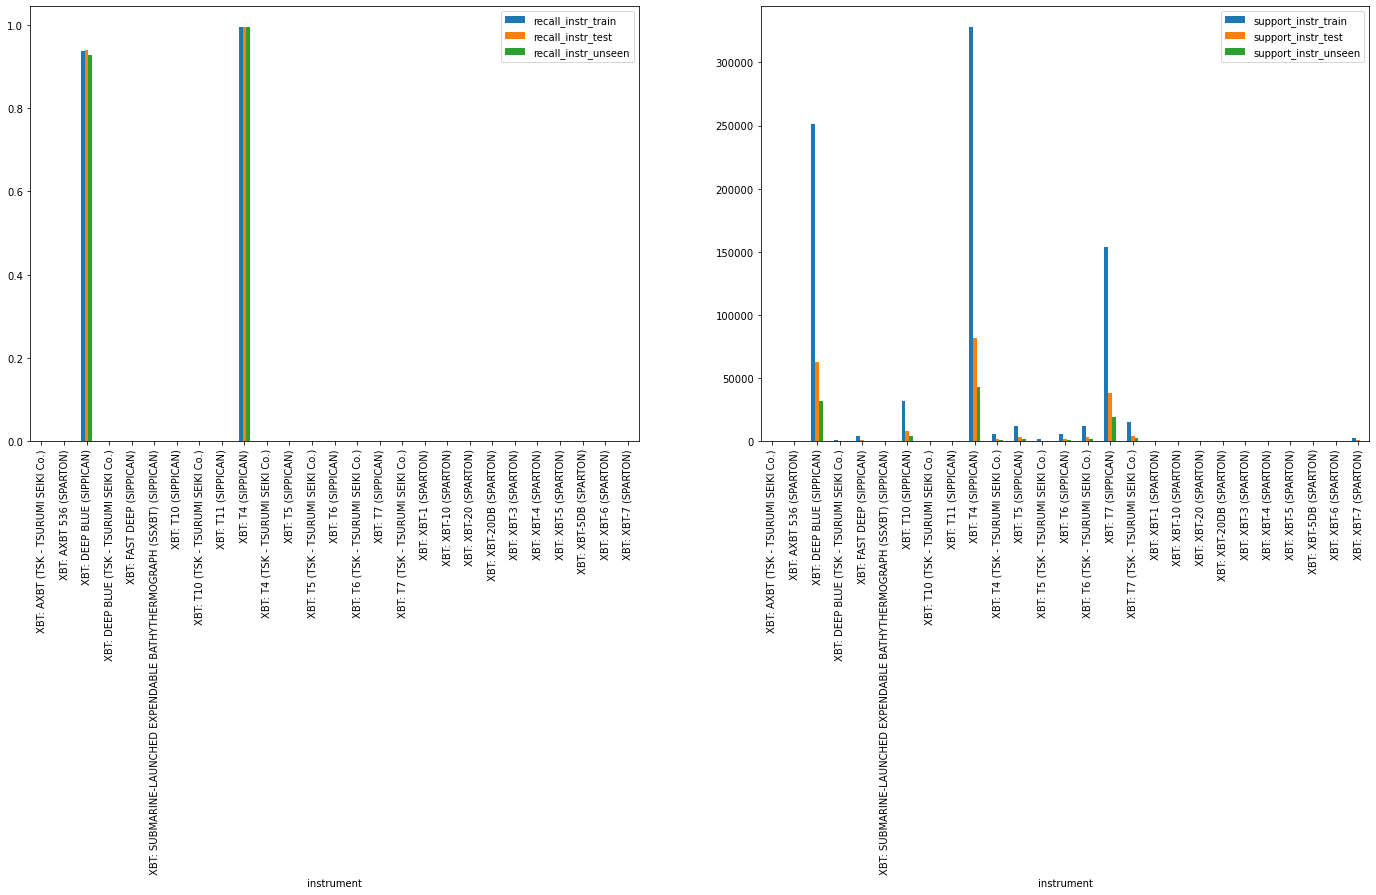

In [39]:
fig_results_all_dt = matplotlib.pyplot.figure('xbt_results_all_dt', figsize=(24,8))
axis_instr_metrics = fig_results_all_dt.add_subplot(121)
_ = df_metrics_per_class_instr.plot.bar(x='instrument', y=['recall_instr_train','recall_instr_test','recall_instr_unseen'],ax=axis_instr_metrics)
axis_instr_support = fig_results_all_dt.add_subplot(122)
_ = df_metrics_per_class_instr.plot.bar(x='instrument',y=['support_instr_train', 'support_instr_test', 'support_instr_unseen'], ax=axis_instr_support)


<AxesSubplot:xlabel='target'>

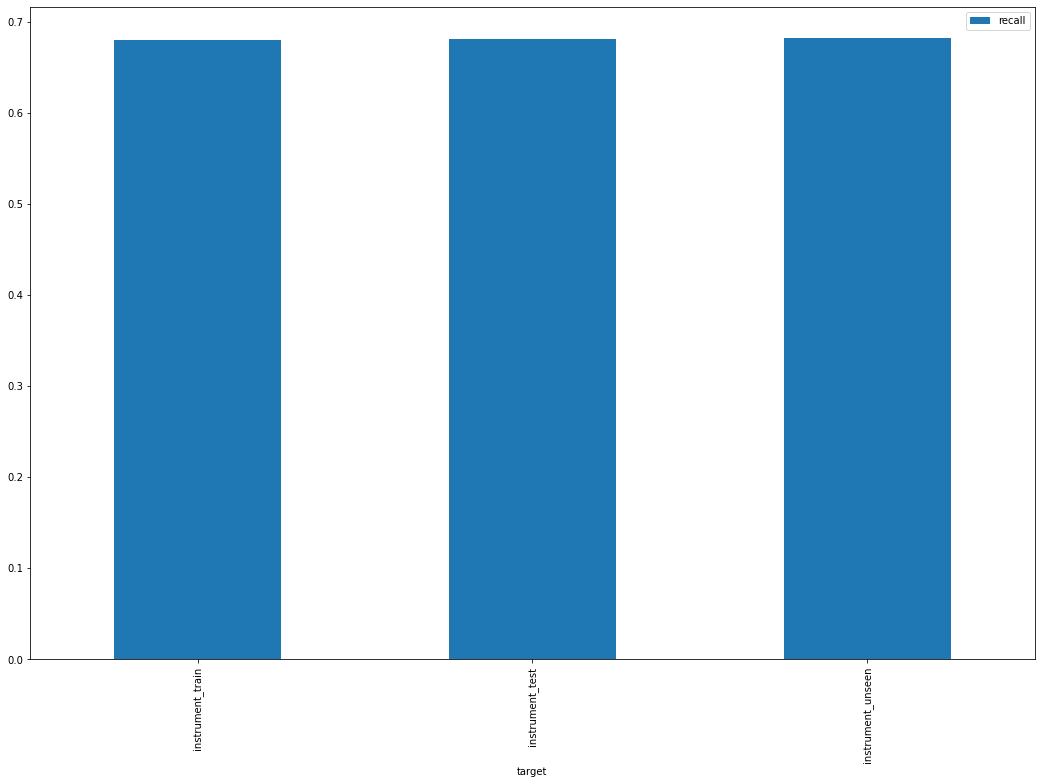

In [40]:
df_metrics_avg.plot.bar(figsize=(18,12), x='target', y='recall')

## Classification results

The contents of the XBT dataset varies over the time period, so previous papers have looked at classification accuracy (recall) year by year to evaluate how performance varies with different distribution of probe types.

To do this we apply the classifier to the train and test data for each year separetly and calculate the metrics year by year.

In [41]:
def score_year(xbt_df, year, clf, input_features, target_feature):
    data_year1 = xbt_df.filter_obs({'year': year}, )
    if data_year1.shape[0] == 0:
        return [0.0, 0.0, 0.0, 0]
    X_year = data_year1.filter_features(input_features).get_ml_dataset()[0]
    y_year = data_year1.filter_features([target_feature]).get_ml_dataset()[0]
    y_res_year = clf.predict(X_year)
    metric_year = sklearn.metrics.precision_recall_fscore_support(
        y_year, y_res_year, average='micro')
    return metric_year

In [42]:
eval_progress = ipywidgets.IntProgress(min=env_date_ranges[environment][0],
                                           max= env_date_ranges[environment][1],
                                          description='Evaluating',
                                          bar_style='info')
eval_progress

IntProgress(value=1966, bar_style='info', description='Evaluating', max=2015, min=1966)

In [43]:
results_by_year = {}

In [44]:
for year in range(*year_range):
    results_by_year[year] = {
        'metric_train_instr' : score_year(xbt_train_all, year, clf_gridcv1, input_feature_names, 'instrument'),
        'metric_test_instr' : score_year(xbt_test_all, year, clf_gridcv1, input_feature_names, 'instrument'),
        'metric_unseen_instr' : score_year(xbt_unseen, year, clf_gridcv1, input_feature_names, 'instrument'),
    }
    eval_progress.value = year


In [45]:
grid_metric_dict = {y1: score_year(xbt_unseen, y1, clf_gridcv1, input_feature_names, 'instrument') for y1 in range(*year_range)}

In [46]:
be_metric_dict = {y1: score_year(xbt_unseen, y1, clf_gridcv1.best_estimator_, input_feature_names, 'instrument') for y1 in range(*year_range)}

In [47]:
clf_dt_instr_single1 = classifier_class(**classifier_opts)

In [48]:
clf_dt_instr_single1.fit(X_train_all,y_instr_train_all)

DecisionTreeClassifier(max_depth=20)

In [49]:
single_metric_dict = {y1: score_year(xbt_unseen, y1, clf_dt_instr_single1, input_feature_names, 'instrument') for y1 in range(*year_range)}

In [50]:
clf_dt_instr_best_params1 = classifier_class(**clf_gridcv1.best_estimator_.get_params())

In [92]:
clf_gridcv1.cv_results_['params'][9]

{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1}

In [93]:
clf_gridcv1.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_min_samples_leaf', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [94]:
clf_gridcv1.cv_results_['split0_test_score'][9]

0.4445025645496418

In [95]:
clf_gridcv1.cv_results_['split1_test_score'][9]

0.3609694433546925

In [96]:
clf_gridcv1.cv_results_['split2_test_score'][9]

0.06203617263186955

In [97]:
clf_gridcv1.cv_results_['mean_test_score'][9]

0.28916939351206794

In [99]:
clf_gridcv1.estimator

DecisionTreeClassifier(max_depth=20)

In [51]:
clf_dt_instr_best_params1.fit(X_train_all,y_instr_train_all)

DecisionTreeClassifier(criterion='entropy', max_depth=1)

In [52]:
best_params_dict = {y1: score_year(xbt_unseen, y1, clf_dt_instr_best_params1, input_feature_names, 'instrument') for y1 in range(*year_range)}

In [53]:
clf_dt_instr_single1.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [54]:
clf_dt_instr_best_params1.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [89]:
clf_gridcv1.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [79]:
metrics_debug1 = [
    sklearn.metrics.precision_recall_fscore_support(y_instr_unseen_all, 
                                                           clf1.predict(X_unseen_all), 
                                                           labels=list(range(0,len(metrics_per_class_all['instrument']))),
                                                    average='micro'
                                                   )
for clf1 in [clf_dt_instr_best_params1, clf_dt_instr_single1, clf_gridcv1, clf_gridcv1.best_estimator_]
]

In [87]:
clf_gridcv1.score(X_train_all, y_instr_train_all)

0.6807325563795974

In [88]:
clf_dt_instr_single1.score(X_train_all, y_instr_train_all)

0.9740033298017254

In [80]:
metrics_debug1

[(0.6825365597744114, 0.6825365597744114, 0.6825365597744114, None),
 (0.9325576384399914, 0.9325576384399914, 0.9325576384399914, None),
 (0.6825365597744114, 0.6825365597744114, 0.6825365597744114, None),
 (0.6825365597744114, 0.6825365597744114, 0.6825365597744114, None)]

<AxesSubplot:>

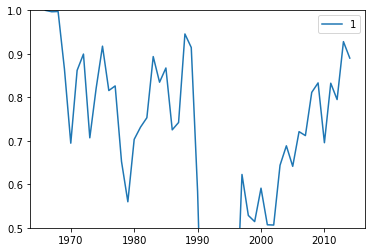

In [57]:
pandas.DataFrame(best_params_dict).transpose().plot.line(y=[1],ylim=[0.5,1.0])

<AxesSubplot:>

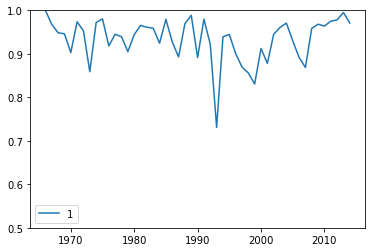

In [58]:
pandas.DataFrame(single_metric_dict).transpose().plot.line(y=[1],ylim=[0.5,1.0])

<AxesSubplot:>

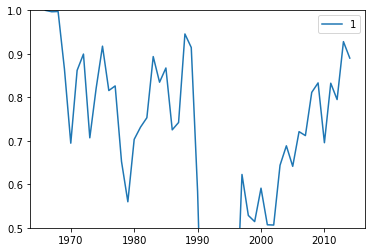

In [59]:
pandas.DataFrame(be_metric_dict).transpose().plot.line(y=[1],ylim=[0.5,1.0])

<AxesSubplot:>

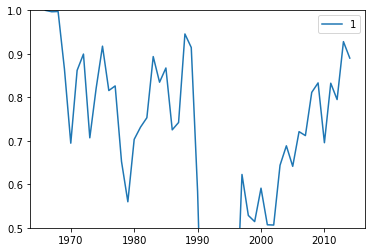

In [60]:
pandas.DataFrame(grid_metric_dict).transpose().plot.line(y=[1],ylim=[0.5,1.0])

In [61]:
recall_by_year = pandas.DataFrame.from_dict({ 
    'year':  list(results_by_year.keys()),
    'recall_train_instr' : [m1['metric_train_instr'][1] for y1,m1 in results_by_year.items()],
    'recall_test_instr' : [m1['metric_test_instr'][1] for y1,m1 in results_by_year.items()],
    'recall_unseen_instr' : [m1['metric_unseen_instr'][1] for y1,m1 in results_by_year.items()],
})


In [62]:
instr_encoder = xbt_labelled._feature_encoders['instrument']

In [63]:
eval_progress.value = env_date_ranges[environment][0]
imeta_results = []
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]):
    y_imeta_instr = instr_encoder.transform(pandas.DataFrame(imeta_instrument[xbt_labelled.xbt_df.year == year]))
    xbt_instr1 = instr_encoder.transform(pandas.DataFrame(xbt_labelled.xbt_df[xbt_labelled.xbt_df.year == year].instrument))
    (im_pr_instr, im_rec_instr, im_f1_instr, im_sup_instr) = sklearn.metrics.precision_recall_fscore_support(xbt_instr1, y_imeta_instr,average='micro')
    imeta_results += [{'year': year,
                       'imeta_instr_recall': im_rec_instr,
                       'imeta_instr_precision': im_pr_instr,
                      }]
    eval_progress.value = year

In [64]:
imeta_res_df = pandas.DataFrame.from_records(imeta_results)

In [65]:
results_df = pandas.merge(recall_by_year, imeta_res_df).merge(
    pandas.DataFrame.from_dict({
        'year': xbt_labelled['year'].value_counts(sort=False).index,
        'num_samples': xbt_labelled['year'].value_counts(sort=False).values,
    }))

In [66]:
clf_gridcv1.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

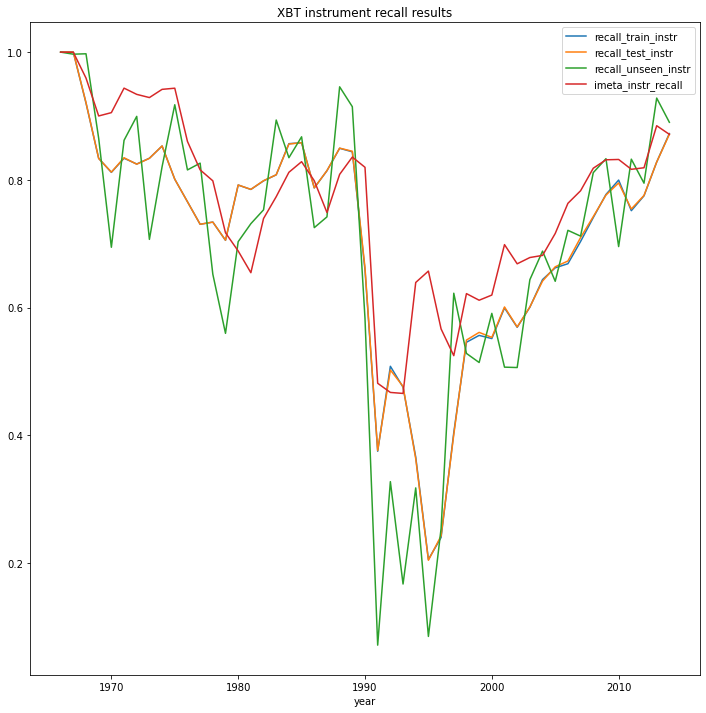

In [67]:
fig_model_recall_results = matplotlib.pyplot.figure('xbt_model_recall', figsize=(12,12))
ax_instr_recall_results = fig_model_recall_results.add_subplot(111, title='XBT instrument recall results')
_ = results_df.plot.line(x='year',y=['recall_train_instr','recall_test_instr', 'recall_unseen_instr', 'imeta_instr_recall'], ax=ax_instr_recall_results)

The results forper year  using only max depth and year agree with the previous plots in this notebook, showing that the results are slightly worse than using either (country, year, max depth) or (lat,lon,max depth, year), but not much worse, supporting the hypothesis that max depth and year contain the most information for predicting probe type, with country or lat/lon contributing less.

In [68]:
# results_df.to_csv(os.path.join(xbt_output_dir,result_fname_template.format(classifier=classifier_name,
#                                                                        suffix=suffix)))

### Outputing the data

To filter based on what profiles we can use for predicting, we need some way of checking each profile we create these checkers from the labelled dataset, because the subset of data that was used for training determines what subset is valid for prediction. For example, if a country is not present in the training data, then the prediction function won't be able to handle that profile to predict a probe model and manufacturer. Profiles that are not handled by the trained classifier will get the label "UNKNOWN".


In [69]:
# checker functions check each element of the profile metadata that could be a problem. The checkers are constructed from the labelled data subset.
checkers_labelled = {f1: c1 for f1, c1 in xbt_labelled.get_checkers().items() if f1 in input_feature_names}

In [70]:
result_feature_name = 'instrument_res_dt'

In [71]:
xbt_predictable = xbt_full_dataset.filter_predictable(checkers_labelled)

In [72]:
res_ml1 = clf_gridcv1.predict(xbt_predictable.filter_features(input_feature_names).get_ml_dataset()[0])
res2 = list(xbt_labelled._feature_encoders['instrument'].inverse_transform(res_ml1).reshape(-1))

In [73]:
xbt_predictable.xbt_df[result_feature_name] = res2

In [74]:
xbt_full_dataset.merge_features(xbt_predictable, [result_feature_name],
                               fill_values = {result_feature_name: UNKNOWN_STR},
                               feature_encoders={result_feature_name: xbt_labelled._feature_encoders['instrument']},
                               target_encoders={result_feature_name: xbt_labelled._target_encoders['instrument']},
                               output_formatters={result_feature_name: cat_output_formatter})

In [75]:
# xbt_full_dataset.output_data(os.path.join(xbt_output_dir, output_fname_template.format(classifier=classifier_name,
#                                                                                   suffix=suffix)),
#                              target_features=[result_feature_name])

## Summary
In this notebook, we have used only the year of profile and max depth, and have shown that these features are the most important out of the three imeta input features (country, max depth, year). This is important because some data XBT data sources, we don't have country information. This shows that we use a fallback set of classifiers trained only on max depth and year for those cases, and we would get performance that is worse than using all three features, but is better than the results from the intelligent metadata algorithm.

In [76]:
clf_gridcv1.best_estimator_.get_params()


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}